# Data Exploration & Analysis for Construction Projects

* The focus is on giving an overview of the tasks, progress and other characteristics of various construction data.
* Basic data manipulation (pandas) and visualization methods (matplotlib) are adopted.
* All data are anonymized.

#### Workflow Summary:
0. Prepare and load data
1. Clean data
2. Look at data at project level
3. Look at data at task level

## 0. Prepare Environment & Load Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns; sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
data = pd.read_csv("Activity_Anonymized_Dataset.csv")
pd.set_option('display.max_columns', len(data.columns))
orig_len = len(data)
orig_col = data.columns

#helper functions
def find_perc(series, r = 2):
    return (series / series.sum() * 100).round(r)

---

## 1. Data Cleaning
### Remove columns that are either all null or all zero

In [3]:
#remove null columns
for col in data.columns:
    if data[col].isna().sum() == len(data): # if all null
        data = data.drop(columns=[col])
        
#remove starttime endtime startime custom, they contains no info
data = data.drop(columns=['starttime','endtime', 'startime','custom'])

print("columns removed: {}".format([x for x in orig_col if x not in data.columns]))

columns removed: ['assetid', 'starttime', 'endtime', 'startime', 'custom', 'tagids']


### Remove rows with missing projectid
\> rows with missing projectid also have missing title, description, planstart/end etc
<br>> **they all have 11e623a37e87cf7995c466723ec99688d55cae8c as their assignees, createdby, deletedby, startedby, completedby**

In [4]:
data = data[data.projectid.notnull()]
print("{} rows removed".format(orig_len - len(data)))

2197 rows removed


### Clean typos in "title" column

In [5]:
#standardize titles
data.title = data.title.replace({
    "Vanity,": "Vanity",
    "Screeding,": "Screeding",
    "Additionnal": "Additional",
    "San.": "San",
    "Vynil": "Vinyl",
    "Windows": "Window",
    "pressure": "Pressure"
});
data['projectid'] = data['projectid'].astype(int)
projectids = sorted(data.projectid.unique().tolist()) 

---

## 2. Projects Overview

### Calculate Durations (Planned vs Actual)

In [6]:
# convert datetime columns to datetime data
data[['planstart','planend','actualstart','actualend','creation date','trackingstart', 'trackingend']] \
= data[['planstart','planend','actualstart','actualend','creation date','trackingstart', 'trackingend']].apply(pd.to_datetime, errors='coerce')

In [7]:
#calculate durations
data['actualhours'] = (data['actualend'] - data['actualstart']).apply(lambda x: x.total_seconds()/3600).clip_lower(0)
data['planhours'] = (data['planend'] - data['planstart']).apply(lambda x: x.total_seconds()/3600).clip_lower(0)
data['exceededhours'] = data['actualhours'] - data['planhours']

---

### Project Teams & Groups Summary

In [8]:
project_summary = pd.DataFrame(data.groupby("projectid").agg({
    'projectid': 'count',
    'teamids': lambda x: x.dropna().nunique(),
    'groupid': lambda x: x.dropna().nunique(),
})).rename(columns={'projectid':'rows', 'teamids':'unique team IDs', 'groupid':'unique group IDs'})

project_summary['rows %'] = find_perc(project_summary['rows'])
col = list(project_summary.columns)
project_summary = project_summary[[col[0]] + [col[-1]] + col[2:0:-1]] # reorder 
project_summary.sort_values('rows', ascending=False)

,unique group IDs,rows %,unique team IDs,rows
projectid,,,,
6,470,63.16,39,27035
2,550,35.82,30,15334
1,25,0.76,1,324
14,2,0.16,20,70
8,15,0.08,0,36
4,2,0.01,0,4


> **Findings**:
<br>1. Only Project 6, 2, 14 have significant tasks recorded

---

### Task Duration Analysis

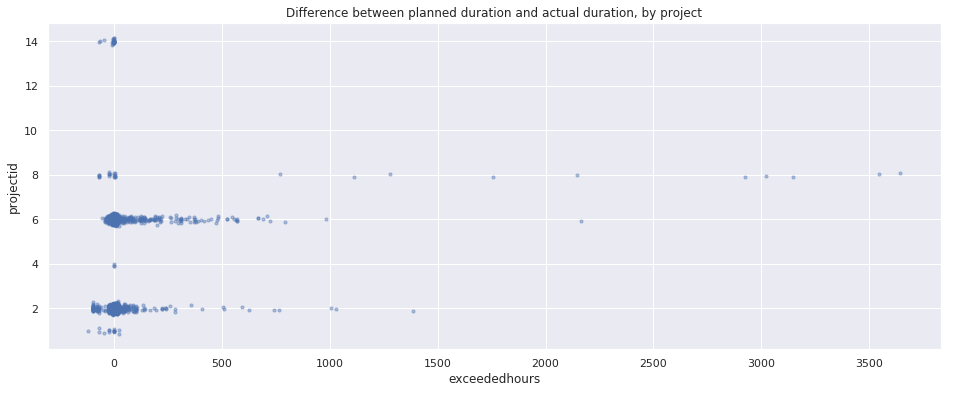

In [9]:
project_delay = data.loc[data.exceededhours.notnull(),['exceededhours', 'projectid']].sort_values('exceededhours')
project_delay['c'] = project_delay.projectid
project_delay.projectid += 0.08*np.random.randn(len(project_delay))
ax = project_delay.plot.scatter(x='exceededhours',y='projectid', s=10,alpha=0.4, figsize=(16,6), c='b',
                               title="Difference between planned duration and actual duration, by project");

---

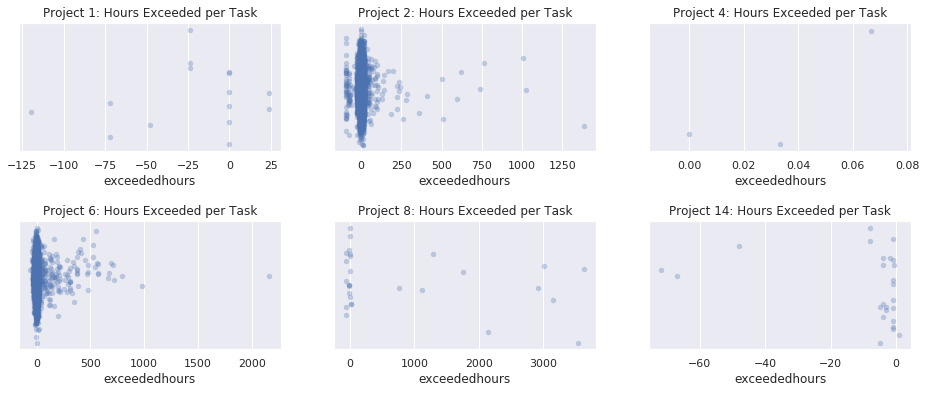

In [10]:
project_delay = data.loc[data.exceededhours.notnull(),['exceededhours', 'projectid']].sort_values('exceededhours')
project_delay['c'] = project_delay.projectid
project_delay.projectid += np.random.randn(len(project_delay))

fig, axes = plt.subplots(2,3, figsize=(14,12))
plt.subplots_adjust(hspace=0.55)
for i in range(6):
    dd = project_delay.loc[project_delay.c == projectids[i],['exceededhours','projectid']]
    ax = dd.plot.scatter(ax=axes[i //3, i% 3], x='exceededhours',y='projectid', s=30,alpha=0.3, figsize=(16,6), c='b',linewidths=0, edgecolors='b',
                         title="Project {}: Hours Exceeded per Task".format(projectids[i]));
    ax.yaxis.set_visible(False)

*NOTE: jitter is added in the y-axis to separate the points visually*
> **Findings**:
<br>1. Project 6 has many tasks taking longer than they should.
<br>2. Project 8 has some tasks that are taking WAY LONGER than they should. **Check data validity!**

---

In [11]:
project_hours = pd.DataFrame(data.loc[data.actualhours.notnull()].groupby("projectid").agg({
    'planhours': 'sum',
    'actualhours': 'sum',
})).rename(columns={'projectid':'rows', 'teamids':'unique team IDs', 'groupid':'unique group IDs'})

project_hours['actualhours % of planhours'] = project_hours['actualhours'] / project_hours['planhours'] * 100
project_hours.round(1)

,actualhours,planhours,actualhours % of planhours
projectid,,,
1,120.1,456.0,26.3
2,46351.2,33594.0,138.0
4,0.1,0.0,inf
6,63301.4,30042.0,210.7
8,24254.1,1363.5,1778.8
14,7.6,253.0,3.0


*NOTE: only completed tasks are included in this calculation*
> **Findings**:
<br>1. Tasks of Project 2 is taking 38% longer than planned.
<br>2. Project 6 110.7% longer.
<br>2. Project 8 1679.8% longer???

---

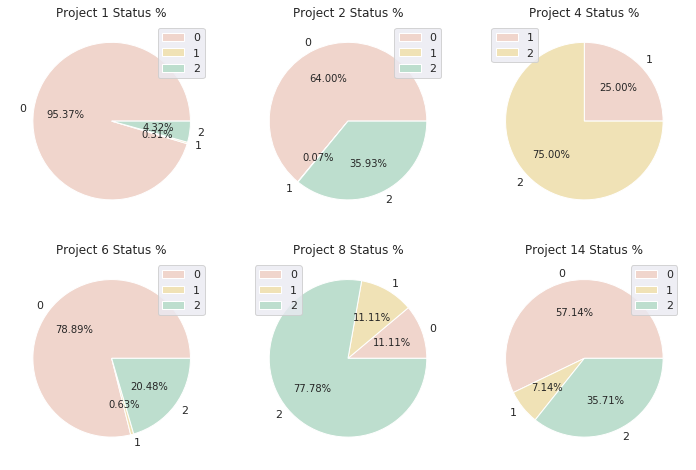

In [12]:
project_status = data[['projectid','status','id']].groupby(['projectid','status']).count()

fig, axes = plt.subplots(2,3, figsize=(12,8))
for i in range(6):
    ax = project_status.loc[projectids[i]].plot.pie(ax=axes[i //3, i% 3], y='id', colors=['#f0d5cc','#f0e2b6','#bddece'],
                                               autopct='%.2f%%', title="Project {} Status %".format(projectids[i]))
    ax.yaxis.set_label_text("");

---

### Top Tasks in Projects

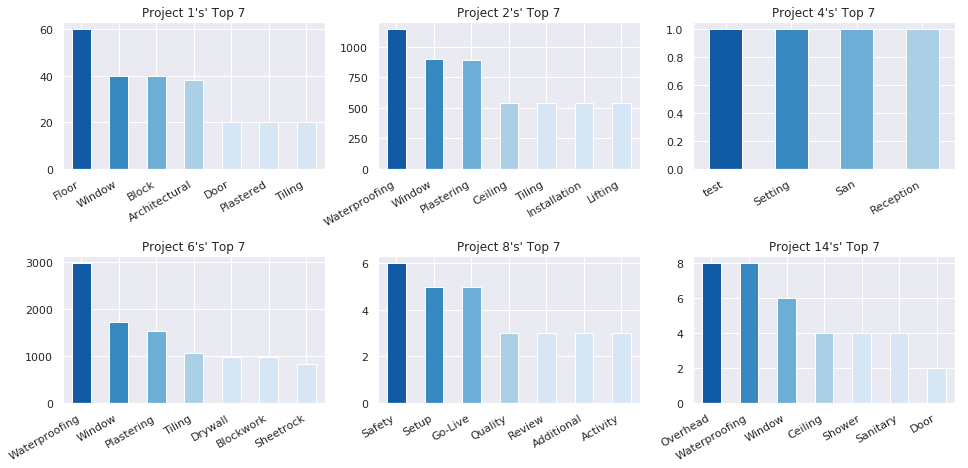

In [59]:
toptasks = data[['id','projectid','title']].groupby(['projectid','title']).count().sort_values('id', ascending=False).reset_index()

N = 7
fig, axes = plt.subplots(2,3, figsize=(16,7))
plt.subplots_adjust(hspace=0.6)
cmap = ListedColormap(sns.color_palette("Blues_r",5))   
for i in range(6):
    ax = toptasks[toptasks.projectid == projectids[i]].head(N).plot.bar(ax=axes[i //3, i% 3], x='title', y='id', rot=30, legend=None,
                                                                color=cmap(np.arange(len(toptasks))),
                                                                title="Project {}'s' Top {}".format(projectids[i], N))
    ax.set_xticklabels(ax.get_xticklabels(), ha='right');
    ax.xaxis.set_label_text("");

> **Findings**:
<br>1. Project 2 and 6 have a lot of *Waterproofing, Window and Plastering* task to do

---

## 3. Tasks Overview

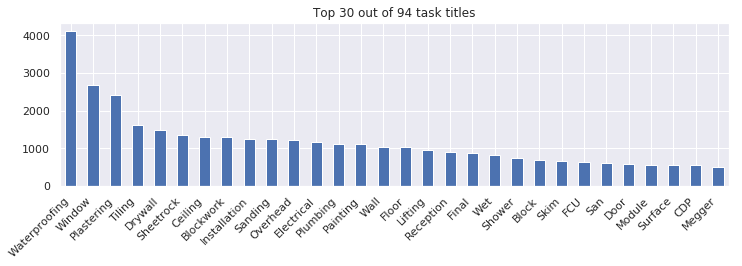

In [284]:
TOP_N_title = 30
title_nunique = data['title'].nunique()
title_counts = data[['title','id']].groupby('title').count().sort_values('id', ascending=False)
ax = title_counts.id[:TOP_N_title].plot.bar(rot=45, legend=None, label=None,
                                         figsize=(12,3), title='Top {} out of {} task titles'.format(TOP_N_title, title_nunique));
ax.set_xticklabels(ax.get_xticklabels(), ha='right');
ax.xaxis.set_label_text("");

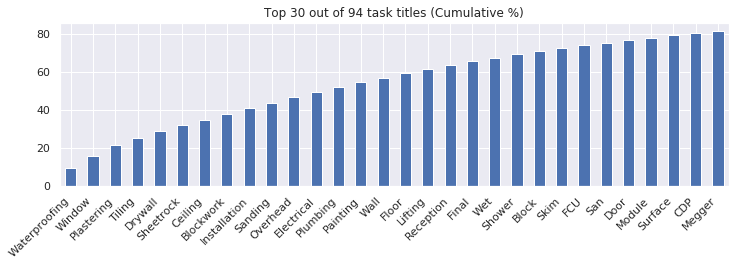

In [283]:
TOP_N_title = 30
title_counts['perc'] = title_counts.id / title_counts.id.sum() * 100
title_counts['perc_cum'] = title_counts['perc'].cumsum()
ax = title_counts.perc_cum[:TOP_N_title].plot.bar(rot=45, legend=None,
                                         figsize=(12,3), title='Top {} out of {} task titles (Cumulative %)'.format(TOP_N_title, title_nunique));
ax.set_xticklabels(ax.get_xticklabels(), ha='right');
ax.xaxis.set_label_text("");

---

>**Suggestions:**
<br>1. Create categories for task titles for better overview
<br>2. Check data validity and how they are entered, for example tasks with extremely long durations